In [1]:
import h5py
import vedo
vedo.settings.default_backend = 'panel'
import plotly.graph_objects as plygo
import numpy as np

import sys
sys.path.insert(0, '/Users/jtlaune/athena/vis/python')
import athena_read as athr

In [2]:
%matplotlib widget
np.set_printoptions(edgeitems=5, linewidth=200, precision=5)

# Previous reading error

<span style='font-size:20px'> (meshblock too small, a meshblock at level 6 cannot cover a cell in level 0) </span>

In [3]:
ds = athr.athdf("work/ppd_cyl.out1.00000.athdf", level=4, fast_restrict=True, quantities=['dens', ], )

/Users/jtlaune/athena/vis/python/athena_read.py:541: AthenaWarning: Requested refinement level higher than maximum level in file: all cells will be prolongated
  warnings.warn('Requested refinement level higher than maximum level in file:'


## Changes made in `athena_read.py`

- line 335:`          center_func_1=None, center_func_2=None, center_func_3=None, num_ghost=0, **kwargs):`

- line 399:`        max_level = kwargs.get("max_level", f.attrs['MaxLevel'])`

# A Hack Fix (Use this)

<span style='font-size:20px'> read in raw data; cast fine data to coarser mesh level by level such that coarse levels have info in refinement area. </span>

In [4]:
class Raw_Data_Restricted:
    
    def __init__(self, filename, q=None, **kwargs):
    
        ds_raw = athr.athdf(filename, raw=True, quantities=q, )
        self.ds_raw = ds_raw
        self.filename = filename
        
        if q is None:  # todo: check if input quantities are included in VariableNames
            self.quantities = [x.decode('ascii', 'replace') for x in ds_raw['VariableNames'][:]]
        elif isinstance(q, str):
            self.quantities = [q, ]
        else:
            self.quantities = q
    
        # mostly copied from athena_read.py
        self.block_size = ds_raw['MeshBlockSize']
        self.root_grid_size = ds_raw['RootGridSize']
        self.levels = ds_raw['Levels'][:]
        self.logical_locations = ds_raw['LogicalLocations'][:]
        self.max_level = ds_raw['MaxLevel']
        
        # for now, if ndim = 2, we assume only the first two dimensions are meaningful
        self.ndim = self.get_ndim()
        
        # w/o knowing this, we'll running into the following error:
        # "Block boundaries at finest level must be cell boundaries at desired level for subsampling or fast restriction to work" 
        block_refine_limit = np.log2(self.block_size)
        self.block_refine_limit = block_refine_limit[block_refine_limit>0].min()
        
        self.restrict_data(min_lev=kwargs.get("min_lev_to_restrict", 0))
        
    def get_level(self, lev, ):
        # construct mesh data from blocks
        
        sel_mb_lev = np.where(self.levels == lev)[0]
        logi_locs = self.logical_locations[sel_mb_lev]
        anchor = logi_locs.min(axis=0)
        logi_locs -= anchor
        Nx_mb = self.block_size
        Nx_lev = Nx_mb * (logi_locs.max(axis=0) + 1)  # b/c locs starts from 0
        
        # reconstruct cell center coordinates
        ccx1, ccx2, ccx3 = np.zeros(Nx_lev[0], dtype=np.float32), np.zeros(Nx_lev[1], dtype=np.float32), np.zeros(Nx_lev[2], dtype=np.float32)
        
        if self.ndim == 2:
            Nx_lev = (Nx_lev[:2])
            
        level_data = {}
        for _q in self.quantities:
            level_data[_q] = np.zeros(Nx_lev[::-1], dtype=np.float32)
        
        for idx_sel_mb, idx_mb in enumerate(sel_mb_lev):
            #print(idx_sel_mb, idx_mb)
            _ccx1, _ccx2, _ccx3 = self.ds_raw['x1v'][idx_mb], self.ds_raw['x2v'][idx_mb], self.ds_raw['x3v'][idx_mb]
            ccx1[Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = _ccx1
            ccx2[Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1)] = _ccx2
            ccx3[Nx_mb[2]*logi_locs[idx_sel_mb][2]:Nx_mb[2]*(logi_locs[idx_sel_mb][2]+1)] = _ccx3
            
            for _q in self.quantities:
                if self.ndim == 2:
                    (level_data[_q])[Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1),
                                     Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = self.ds_raw[_q][idx_mb]
                if self.ndim == 3:
                    (level_data[_q])[Nx_mb[2]*logi_locs[idx_sel_mb][2]:Nx_mb[2]*(logi_locs[idx_sel_mb][2]+1), 
                                     Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1),
                                     Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = self.ds_raw[_q][idx_mb]
        
        return [ccx1, ccx2, ccx3], level_data
    
        
    def restrict_data(self, min_lev = 0):
        # restrict data level by level, from the finest level to root level
        
        for lev in range(self.max_level, min_lev, -1):
            
            logi_locs = self.logical_locations[self.levels==lev]
            logi_locs_parent = logi_locs // 2

            # to find and group fine mesh blocks that can be merged into one coarse mesh blocks
            unq, count = np.unique(logi_locs_parent, axis=0, return_counts=True)
            repeated_groups = unq[count>1]

            re_levels = []
            re_logi_locs = []
            re_data = {'x1f': [], 'x1v': [], 'x2f': [], 'x2v': [], 'x3f': [], 'x3v': [], }
            for _q in self.quantities:
                re_data[_q] = []

            for repeated_group in repeated_groups:
                repeated_idx = np.argwhere(np.all(logi_locs_parent == repeated_group, axis=1))
                #print(repeated_idx.ravel()) # one can check this so we know it is 2D or 3D

                # hard-coded for 3D (but seems to also work in 2D so far)
                idx_to_merge = np.argwhere(self.levels==lev)[repeated_idx.ravel()].ravel()

                # athr.athdf uses face coordinates to find the enclosure boundaries, so center-coordiantes are fine to capture the mesh blocks
                bounding_box = np.array([[self.ds_raw['x1v'][idx_to_merge].min(), self.ds_raw['x1v'][idx_to_merge].max()], 
                                         [self.ds_raw['x2v'][idx_to_merge].min(), self.ds_raw['x2v'][idx_to_merge].max()], 
                                         [self.ds_raw['x3v'][idx_to_merge].min(), self.ds_raw['x3v'][idx_to_merge].max()], 
                                        ])
                
                _ds = athr.athdf(self.filename, level=lev-1, fast_restrict=True, quantities=self.quantities, 
                                 max_level=min(self.max_level, lev-1 + self.block_refine_limit),
                                 x1_min=bounding_box[0][0], x1_max=bounding_box[0][1], 
                                 x2_min=bounding_box[1][0], x2_max=bounding_box[1][1], 
                                 x3_min=bounding_box[2][0], x3_max=bounding_box[2][1], )

                re_levels.append(lev-1)
                re_logi_locs.append(repeated_group)
                for _coord in ['x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', ]:
                    re_data[_coord].append(_ds[_coord])
                for _q in self.quantities:
                    re_data[_q].append(_ds[_q])

            self.levels = np.hstack([self.levels, np.atleast_1d(re_levels)])
            self.logical_locations = np.vstack([self.logical_locations, np.array(re_logi_locs)])
            for _coord in ['x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', ]:
                self.ds_raw[_coord] = np.vstack([self.ds_raw[_coord], np.array(re_data[_coord])])
            for _q in self.quantities:
                self.ds_raw[_q] = np.vstack([self.ds_raw[_q], np.array(re_data[_q])])
        
    def get_ndim(self, num_ghost = 0):
        
        # mostly copied from athena_read.py
        nx_vals = []
        for d in range(3):
            if self.block_size[d] == 1 and self.root_grid_size[d] > 1:  # sum or slice
                other_locations = [location
                                   for location in zip(self.levels,
                                                       self.logical_locations[:, (d+1) % 3],
                                                       self.logical_locations[:, (d+2) % 3])]
                if len(set(other_locations)) == len(other_locations):  # effective slice
                    nx_vals.append(1)
                else:  # nontrivial sum
                    num_blocks_this_dim = 0
                    for level_this_dim, loc_this_dim in zip(self.levels,
                                                            self.logical_locations[:, d]):
                        if level_this_dim <= level:
                            possible_max = (loc_this_dim+1) * 2**(level-level_this_dim)
                            num_blocks_this_dim = max(num_blocks_this_dim, possible_max)
                        else:
                            possible_max = (loc_this_dim+1) // 2**(level_this_dim-level)
                            num_blocks_this_dim = max(num_blocks_this_dim, possible_max)
                    nx_vals.append(num_blocks_this_dim)
            elif self.block_size[d] == 1:  # singleton dimension
                nx_vals.append(1)
            else:  # normal case
                nx_vals.append(self.root_grid_size[d] * 2**self.max_level + 2 * num_ghost)
        nx1 = nx_vals[0]
        nx2 = nx_vals[1]
        nx3 = nx_vals[2]
        lx1 = nx1 // self.block_size[0]
        lx2 = nx2 // self.block_size[1]
        lx3 = nx3 // self.block_size[2]
        num_extended_dims = 0
        for nx in nx_vals:
            if nx > 1:
                num_extended_dims += 1
                
        return num_extended_dims

## Accreting Case

In [5]:
ds = Raw_Data_Restricted("work/ppd_cyl.out1.00000.athdf", q = ['dens', ])

ValueError: zero-size array to reduction operation minimum which has no identity

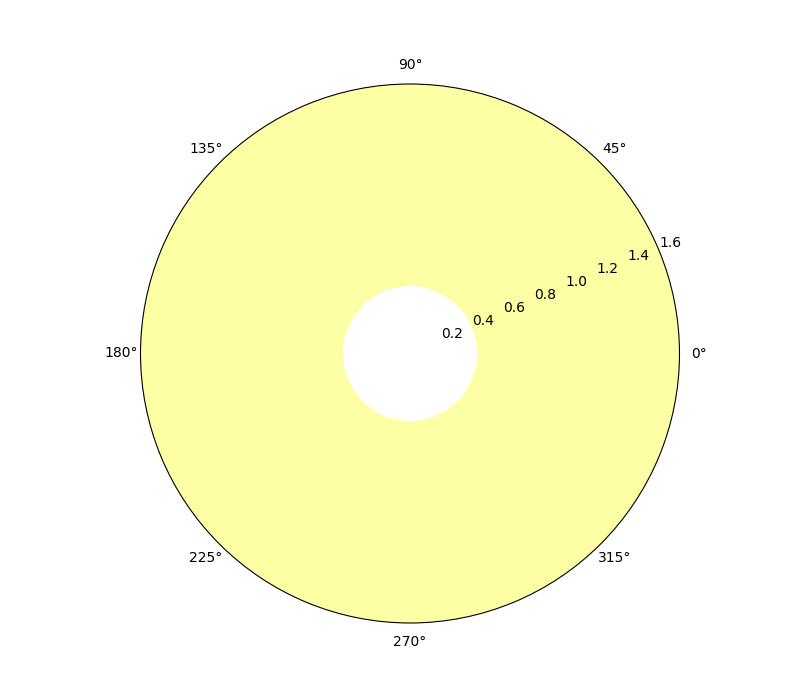

In [6]:
%%capture --no-display
# above is to ignore warning messages of log(negative)
import matplotlib.pyplot as plt
#rxplt.plt_params('l'); 
fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={'projection': 'polar'}); ax.grid(False)

# go through level 0 and 4 and plot them
for lev in [0, 4]:
    cccs, lds = ds.get_level(lev) # meaning: cell center coordinates, level data set
    meshr, meshphi = np.meshgrid(cccs[0], cccs[1])
    im = ax.pcolormesh(meshphi, meshr, np.log10(lds['dens']), shading='nearest', cmap="inferno", vmin=-4, vmax=-2.4)

ax.set_rticks([]); ax.set_thetagrids([]); ax.set_rorigin(0); #ax.set_rlim([1, 4])
#ax.set_rlabel_position(-22.5) # in angle
cax = fig.colorbar(im); cax.ax.set_title(r"$\log \Sigma_{\rm gas}$")

def format_coord(_theta, _r):
    # _theta is from 0 to 2pi
        return f'θ={_theta/np.pi:.3f}π ({_theta*180/np.pi:.1f}°), r={_r:.3f}'

ax.format_coord = format_coord
fig.suptitle(r"$t="+f"{ds.ds_raw['Time']/(2*np.pi):.2f}"+r"P$", fontsize=20); fig.tight_layout()

In [ ]:
# omit q will read in all the quantities
ds = Raw_Data_Restricted("JTrunII_Acc/ppd_cyl.out1.00485.athdf") #, q = ['dens', ])

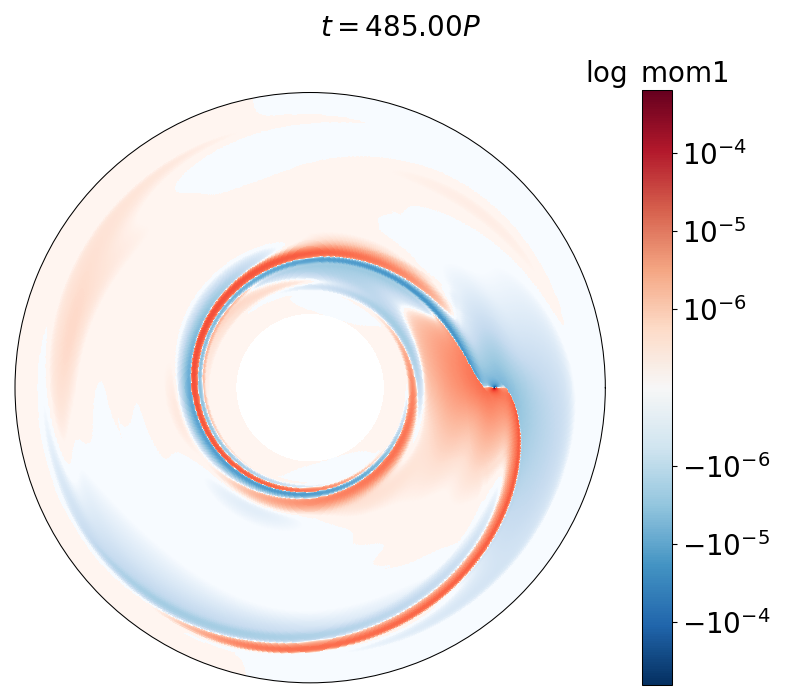

In [126]:
%%capture --no-display
rxplt.plt_params('l'); fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={'projection': 'polar'}); ax.grid(False)

for lev in [0, 4]:
    cccs, lds = ds.get_level(lev) # meaning: cell center coordinates, level data set
    meshr, meshphi = np.meshgrid(cccs[0], cccs[1])
    im = ax.pcolormesh(meshphi, meshr, np.log10(lds['mom1']), shading='nearest', cmap="Reds", vmin=-7, vmax=-3.2)
    im = ax.pcolormesh(meshphi, meshr, np.log10(-lds['mom1']), shading='nearest', cmap="Blues", vmin=-7, vmax=-3.2)

im = ax.pcolormesh([[]], cmap='RdBu_r', vmin=-3.8, vmax=3.8, rasterized=True)
cax = fig.colorbar(im); cax.set_ticks([-3, -2, -1, 1, 2, 3]); cax.ax.set_title(r"$\log$ mom1")
cax.set_ticklabels([r'$-10^{'+str(x)+'}$' for x in [-4, -5, -6]] + [r'$10^{'+str(x)+'}$' for x in [-6, -5, -4]])    

ax.set_rticks([]); ax.set_thetagrids([]); ax.set_rorigin(0); #ax.set_rlim([1, 4])
#ax.set_rlabel_position(-22.5) # in angle

def format_coord(_theta, _r):
    # _theta is from 0 to 2pi
        return f'θ={_theta/np.pi:.3f}π ({_theta*180/np.pi:.1f}°), r={_r:.3f}'

ax.format_coord = format_coord
fig.suptitle(r"$t="+f"{ds.ds_raw['Time']/(2*np.pi):.2f}"+r"P$", fontsize=20); fig.tight_layout()

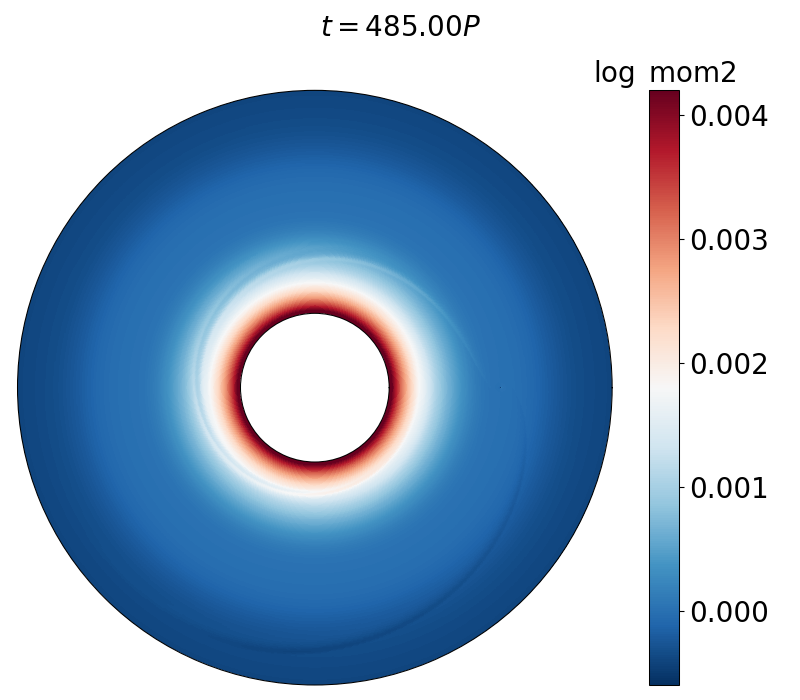

In [140]:
%%capture --no-display
# above is to ignore warning messages of log(negative)

rxplt.plt_params('l'); fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={'projection': 'polar'}); ax.grid(False)

for lev in [0, 4]:
    cccs, lds = ds.get_level(lev) # meaning: cell center coordinates, level data set
    meshr, meshphi = np.meshgrid(cccs[0], cccs[1])
    im = ax.pcolormesh(meshphi, meshr, lds['mom2'], shading='nearest', cmap="RdBu_r", vmin=-0.0006, vmax=0.0042)

cax = fig.colorbar(im); cax.ax.set_title(r"$\log$ mom2")
ax.set_rticks([]); ax.set_thetagrids([]); ax.set_rorigin(0); #ax.set_rlim([1, 4])
#ax.set_rlabel_position(-22.5) # in angle

def format_coord(_theta, _r):
    # _theta is from 0 to 2pi
        return f'θ={_theta/np.pi:.3f}π ({_theta*180/np.pi:.1f}°), r={_r:.3f}'

ax.format_coord = format_coord
fig.suptitle(r"$t="+f"{ds.ds_raw['Time']/(2*np.pi):.2f}"+r"P$", fontsize=20); fig.tight_layout()

In [141]:
lds['mom3']

array([[0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.]], dtype=float32)

In [8]:
ds = Raw_Data_Restricted("JTrunII_Acc/ppd_cyl.out1.00500.athdf", q = ['dens', ])

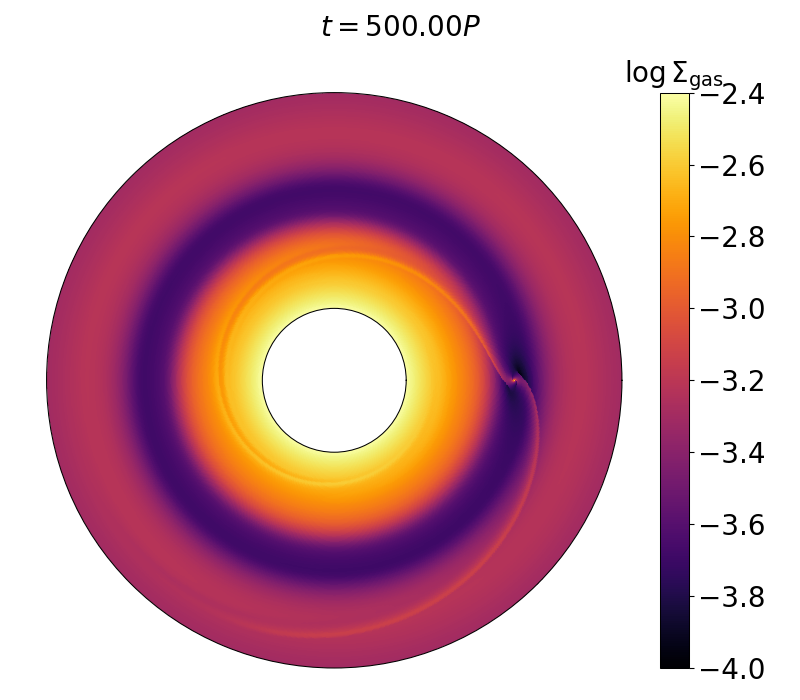

In [9]:
%%capture --no-display
# above is to ignore warning messages of log(negative)

rxplt.plt_params('l'); fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={'projection': 'polar'}); ax.grid(False)

# go through level 0 and 4 and plot them
for lev in [0, 4]:
    cccs, lds = ds.get_level(lev) # meaning: cell center coordinates, level data set
    meshr, meshphi = np.meshgrid(cccs[0], cccs[1])
    im = ax.pcolormesh(meshphi, meshr, np.log10(lds['dens']), shading='nearest', cmap="inferno", vmin=-4, vmax=-2.4)

ax.set_rticks([]); ax.set_thetagrids([]); ax.set_rorigin(0); #ax.set_rlim([1, 4])
#ax.set_rlabel_position(-22.5) # in angle
cax = fig.colorbar(im); cax.ax.set_title(r"$\log \Sigma_{\rm gas}$")

def format_coord(_theta, _r):
    # _theta is from 0 to 2pi
        return f'θ={_theta/np.pi:.3f}π ({_theta*180/np.pi:.1f}°), r={_r:.3f}'

ax.format_coord = format_coord
fig.suptitle(r"$t="+f"{ds.ds_raw['Time']/(2*np.pi):.2f}"+r"P$", fontsize=20); fig.tight_layout()

## Non-accreting case

In [146]:
ds = Raw_Data_Restricted("JTrunII_noAcc/ppd_cyl.out1.00485.athdf")

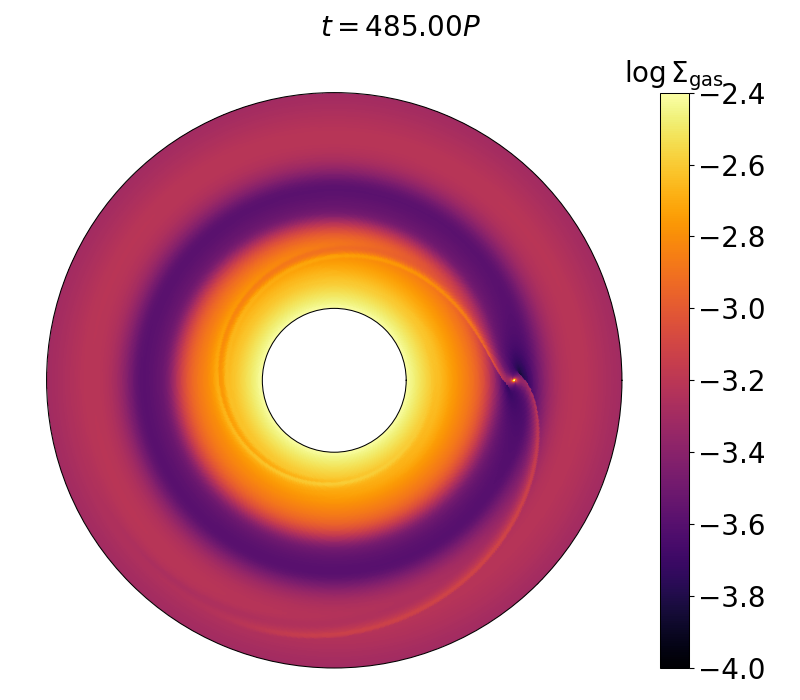

In [147]:
%%capture --no-display
# above is to ignore warning messages of log(negative)

rxplt.plt_params('l'); fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={'projection': 'polar'}); ax.grid(False)

for lev in [0, 4]:
    cccs, lds = ds.get_level(lev) # meaning: cell center coordinates, level data set
    meshr, meshphi = np.meshgrid(cccs[0], cccs[1])
    im = ax.pcolormesh(meshphi, meshr, np.log10(lds['dens']), shading='nearest', cmap="inferno", vmin=-4, vmax=-2.4)

ax.set_rticks([]); ax.set_thetagrids([]); ax.set_rorigin(0); #ax.set_rlim([1, 4])
#ax.set_rlabel_position(-22.5) # in angle
cax = fig.colorbar(im); cax.ax.set_title(r"$\log \Sigma_{\rm gas}$")

def format_coord(_theta, _r):
    # _theta is from 0 to 2pi
        return f'θ={_theta/np.pi:.3f}π ({_theta*180/np.pi:.1f}°), r={_r:.3f}'

ax.format_coord = format_coord
fig.suptitle(r"$t="+f"{ds.ds_raw['Time']/(2*np.pi):.2f}"+r"P$", fontsize=20); fig.tight_layout()

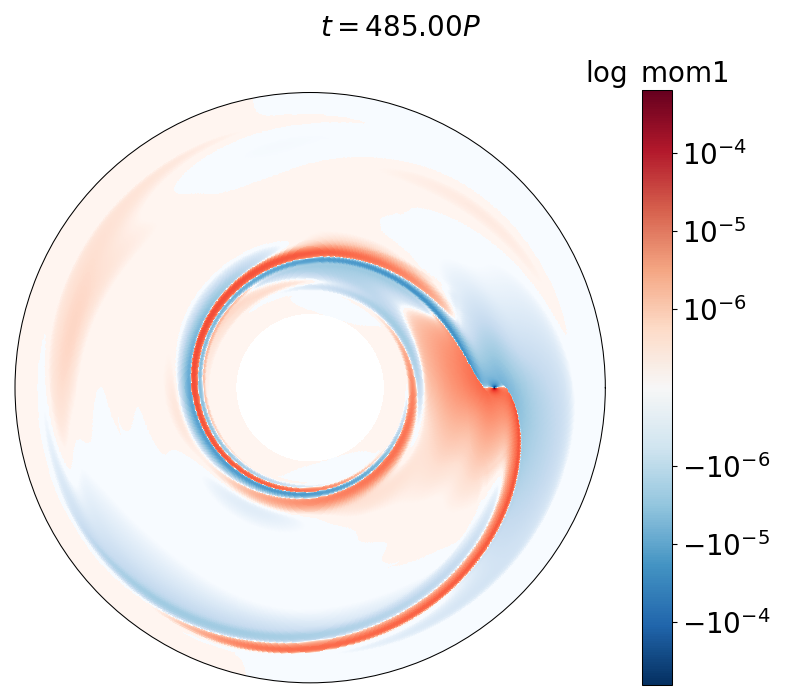

In [148]:
%%capture --no-display
rxplt.plt_params('l'); fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={'projection': 'polar'}); ax.grid(False)

for lev in [0, 4]:
    cccs, lds = ds.get_level(lev) # meaning: cell center coordinates, level data set
    meshr, meshphi = np.meshgrid(cccs[0], cccs[1])
    im = ax.pcolormesh(meshphi, meshr, np.log10(lds['mom1']), shading='nearest', cmap="Reds", vmin=-7, vmax=-3.2)
    im = ax.pcolormesh(meshphi, meshr, np.log10(-lds['mom1']), shading='nearest', cmap="Blues", vmin=-7, vmax=-3.2)

im = ax.pcolormesh([[]], cmap='RdBu_r', vmin=-3.8, vmax=3.8, rasterized=True)
cax = fig.colorbar(im); cax.set_ticks([-3, -2, -1, 1, 2, 3]); cax.ax.set_title(r"$\log$ mom1")
cax.set_ticklabels([r'$-10^{'+str(x)+'}$' for x in [-4, -5, -6]] + [r'$10^{'+str(x)+'}$' for x in [-6, -5, -4]])    

ax.set_rticks([]); ax.set_thetagrids([]); ax.set_rorigin(0); #ax.set_rlim([1, 4])
#ax.set_rlabel_position(-22.5) # in angle

def format_coord(_theta, _r):
    # _theta is from 0 to 2pi
        return f'θ={_theta/np.pi:.3f}π ({_theta*180/np.pi:.1f}°), r={_r:.3f}'

ax.format_coord = format_coord
fig.suptitle(r"$t="+f"{ds.ds_raw['Time']/(2*np.pi):.2f}"+r"P$", fontsize=20); fig.tight_layout()

In [10]:
ds = Raw_Data_Restricted("JTrunII_noAcc/ppd_cyl.out1.00500.athdf", q = ['dens', ])

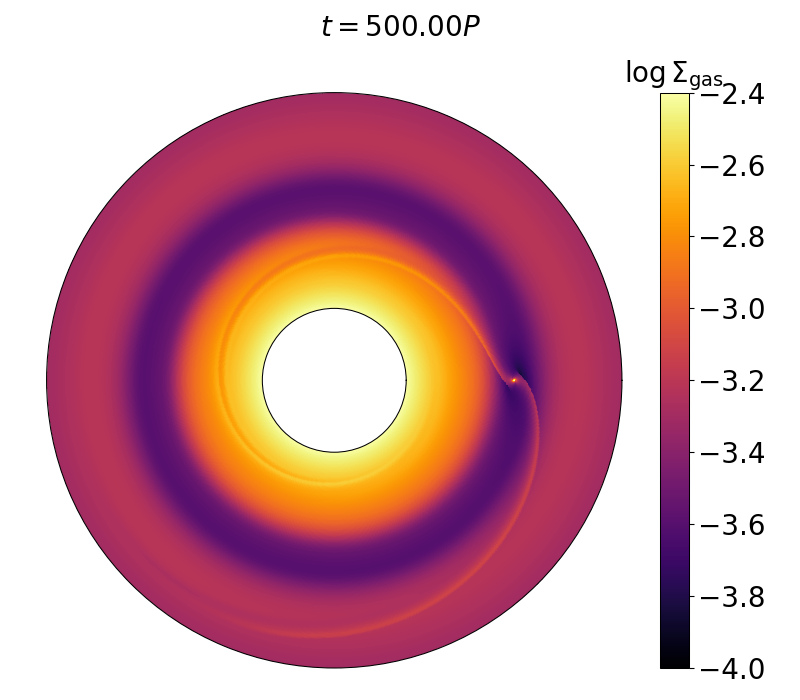

In [11]:
%%capture --no-display
# above is to ignore warning messages of log(negative)

rxplt.plt_params('l'); fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={'projection': 'polar'}); ax.grid(False)

for lev in [0, 4]:
    cccs, lds = ds.get_level(lev) # meaning: cell center coordinates, level data set
    meshr, meshphi = np.meshgrid(cccs[0], cccs[1])
    im = ax.pcolormesh(meshphi, meshr, np.log10(lds['dens']), shading='nearest', cmap="inferno", vmin=-4, vmax=-2.4)

ax.set_rticks([]); ax.set_thetagrids([]); ax.set_rorigin(0); #ax.set_rlim([1, 4])
#ax.set_rlabel_position(-22.5) # in angle
cax = fig.colorbar(im); cax.ax.set_title(r"$\log \Sigma_{\rm gas}$")

def format_coord(_theta, _r):
    # _theta is from 0 to 2pi
        return f'θ={_theta/np.pi:.3f}π ({_theta*180/np.pi:.1f}°), r={_r:.3f}'

ax.format_coord = format_coord
fig.suptitle(r"$t="+f"{ds.ds_raw['Time']/(2*np.pi):.2f}"+r"P$", fontsize=20); fig.tight_layout()

# Initial Experiments

In [68]:
ds_raw = athr.athdf("JTrunII_Acc/ppd_cyl.out1.00485.athdf", raw=True, quantities=['dens', ], )

block_size = ds_raw['MeshBlockSize']
root_grid_size = ds_raw['RootGridSize']
levels = ds_raw['Levels'][:]
logical_locations = ds_raw['LogicalLocations'][:]
max_level = ds_raw['MaxLevel']

In [71]:
nx_vals = []; num_ghost = 0
for d in range(3):
    if block_size[d] == 1 and root_grid_size[d] > 1:  # sum or slice
        other_locations = [location
                           for location in zip(levels,
                                               logical_locations[:, (d+1) % 3],
                                               logical_locations[:, (d+2) % 3])]
        if len(set(other_locations)) == len(other_locations):  # effective slice
            nx_vals.append(1)
        else:  # nontrivial sum
            num_blocks_this_dim = 0
            for level_this_dim, loc_this_dim in zip(levels,
                                                    logical_locations[:, d]):
                if level_this_dim <= level:
                    possible_max = (loc_this_dim+1) * 2**(level-level_this_dim)
                    num_blocks_this_dim = max(num_blocks_this_dim, possible_max)
                else:
                    possible_max = (loc_this_dim+1) // 2**(level_this_dim-level)
                    num_blocks_this_dim = max(num_blocks_this_dim, possible_max)
            nx_vals.append(num_blocks_this_dim)
    elif block_size[d] == 1:  # singleton dimension
        nx_vals.append(1)
    else:  # normal case
        nx_vals.append(root_grid_size[d] * 2**max_level + 2 * num_ghost)
nx1 = nx_vals[0]
nx2 = nx_vals[1]
nx3 = nx_vals[2]
lx1 = nx1 // block_size[0]
lx2 = nx2 // block_size[1]
lx3 = nx3 // block_size[2]
num_extended_dims = 0
for nx in nx_vals:
    if nx > 1:
        num_extended_dims += 1

In [72]:
num_extended_dims

2

In [51]:
for lev in [6, 5, 4, 3, 2, 1]:
    logi_locs = logical_locations[levels==lev]
    logi_locs_parent = logi_locs // 2
    logi_locs_parent

    # to find and group fine mesh blocks that can be merged into coarse mesh blocks
    unq, count = np.unique(logi_locs_parent, axis=0, return_counts=True)
    repeated_groups = unq[count>1]
    
    re_levels = []
    re_logi_locs = []
    re_data = {'x1f': [], 'x1v': [], 'x2f': [], 'x2v': [], 'x3f': [], 'x3v': [], 
               'dens': [], }

    for repeated_group in repeated_groups:
        repeated_idx = np.argwhere(np.all(logi_locs_parent == repeated_group, axis=1))
        print(repeated_idx.ravel()) # one can check this so we know it is 3D

        # hard-coded for 3D
        idx_to_merge = np.argwhere(levels==lev)[repeated_idx.ravel()].ravel()

        # athr.athdf uses face coordinates to find the enclosure boundaries, so center-coordiantes are fine to capture the mesh blocks
        bounding_box = np.array([[ds_raw['x1v'][idx_to_merge].min(), ds_raw['x1v'][idx_to_merge].max()], 
                                 [ds_raw['x2v'][idx_to_merge].min(), ds_raw['x2v'][idx_to_merge].max()], 
                                 [ds_raw['x3v'][idx_to_merge].min(), ds_raw['x3v'][idx_to_merge].max()], 
                                ])
        #print(bounding_box)

        ds = athr.athdf("JTrunII_Acc/ppd_cyl.out1.00485.athdf", level=lev-1, fast_restrict=True, quantities=['dens', ], max_level=min(6, lev-1+4),
                    x1_min=bounding_box[0][0], x1_max=bounding_box[0][1], x2_min=bounding_box[1][0], x2_max=bounding_box[1][1], x3_min=bounding_box[2][0], x3_max=bounding_box[2][1], )

        re_levels.append(lev-1)
        re_logi_locs.append(repeated_group)
        for _coord in ['x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', ]:
            re_data[_coord].append(ds[_coord])
        for _q in ['dens', ]:
            re_data[_q].append(ds[_q])

    levels = np.hstack([levels, np.atleast_1d(re_levels)])
    logical_locations = np.vstack([logical_locations, np.array(re_logi_locs)])
    for _coord in ['x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', ]:
        ds_raw[_coord] = np.vstack([ds_raw[_coord], np.array(re_data[_coord])])
    for _q in ['dens', ]:
        ds_raw[_q] = np.vstack([ds_raw[_q], np.array(re_data[_q])])

[0 1 2 3]
[ 8  9 10 11]
[4 5 6 7]
[12 13 14 15]
[ 0  1  2 12]
[ 6  7  8 13]
[ 3  4  5 14]
[ 9 10 11 15]
[0 1 2 3]
[30 31 32 33]
[4 5 6 7]
[34 35 36 37]
[ 8  9 10 11]
[38 39 40 41]
[12 13 14 60]
[42 43 44 61]
[15 16 17 62]
[45 46 47 63]
[18 19 20 21]
[48 49 50 51]
[22 23 24 25]
[52 53 54 55]
[26 27 28 29]
[56 57 58 59]
[0 1 2 3]
[16 17 18 19]
[ 4  5 32 34]
[20 21 33 35]
[ 6  7 36 38]
[22 23 37 39]
[ 8  9 40 42]
[24 25 41 43]
[10 11 44 46]
[26 27 45 47]
[12 13 14 15]
[28 29 30 31]
[ 0  1  2 20]
[10 11 12 21]
[ 3  4 22 24]
[13 14 23 25]
[ 5  6 26 28]
[15 16 27 29]
[ 7  8  9 30]
[17 18 19 31]
[0 1 2 3]
[12 13 14 15]
[ 4  5 24 26]
[16 17 25 27]
[ 6  7 28 30]
[18 19 29 31]
[ 8  9 10 11]
[20 21 22 23]


In [52]:
levels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 6, 6, 5, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 3, 3, 3, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 3, 3, 3, 3, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 5, 6, 6, 6,
       6, 5, 5, 4, 4, 3, 3, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 5, 5, 5, 4, 4, 4, 4,
     

In [53]:
lev = 0
sel_mb_lev = np.where(levels == lev)[0]
logi_locs = logical_locations[sel_mb_lev]
anchor = logi_locs.min(axis=0)
logi_locs -= anchor
Nx_mb = ds_raw['MeshBlockSize']
Nx_lev = Nx_mb * (logi_locs.max(axis=0) + 1)  # b/c locs starts from 0

In [30]:
(Nx_lev[:2])[::-1]

array([1536,  256])

In [54]:
Nx_lev = (Nx_lev[:2]) # only 2 dimension

In [55]:
dens_lev0 = np.zeros(Nx_lev[::-1], dtype=np.float32)
ccr, ccphi = np.zeros(Nx_lev[0], dtype=np.float32), np.zeros(Nx_lev[1], dtype=np.float32)

for idx_sel_mb, idx_mb in enumerate(sel_mb_lev):
    #print(idx_sel_mb, idx_mb)
    _ccr, _ccphi = ds_raw['x1v'][idx_mb], ds_raw['x2v'][idx_mb]
    ccr[Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = _ccr
    ccphi[Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1)] = _ccphi
    
    dens_lev0[Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1),
              Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = ds_raw['dens'][idx_mb]

In [15]:
dens_lev0

array([[0.00391829, 0.0038508 , 0.00378523, ..., 0.00049958, 0.00049738,
        0.00049519],
       [0.00391829, 0.0038508 , 0.00378523, ..., 0.00049958, 0.00049738,
        0.00049519],
       [0.00391829, 0.0038508 , 0.00378523, ..., 0.00049958, 0.00049738,
        0.00049519],
       ...,
       [0.00391829, 0.0038508 , 0.00378523, ..., 0.00049958, 0.00049738,
        0.00049519],
       [0.00391829, 0.0038508 , 0.00378523, ..., 0.00049958, 0.00049738,
        0.00049519],
       [0.00391829, 0.0038508 , 0.00378523, ..., 0.00049958, 0.00049738,
        0.00049519]], dtype=float32)

In [56]:
lev = 4
sel_mb_lev = np.where(levels == lev)[0]
logi_locs = logical_locations[sel_mb_lev]
anchor = logi_locs.min(axis=0)
logi_locs -= anchor
Nx_mb = ds_raw['MeshBlockSize']
Nx_lev = Nx_mb * (logi_locs.max(axis=0) + 1)  # b/c locs starts from 0
Nx_lev = (Nx_lev[:2]) # only 2 dimension
dens_lev4 = np.zeros(Nx_lev[::-1], dtype=np.float32)
ccr4, ccphi4 = np.zeros(Nx_lev[0], dtype=np.float32), np.zeros(Nx_lev[1], dtype=np.float32)

for idx_sel_mb, idx_mb in enumerate(sel_mb_lev):
    #print(idx_sel_mb, idx_mb)
    _ccr, _ccphi = ds_raw['x1v'][idx_mb], ds_raw['x2v'][idx_mb]
    ccr4[Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = _ccr
    ccphi4[Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1)] = _ccphi
    
    dens_lev4[Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1),
              Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = ds_raw['dens'][idx_mb]

/tmp/ipykernel_27674/3200231020.py:4: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(meshphi, meshr, np.log10(dens_lev0), shading='nearest', cmap="inferno", vmin=-4, vmax=-2.4)


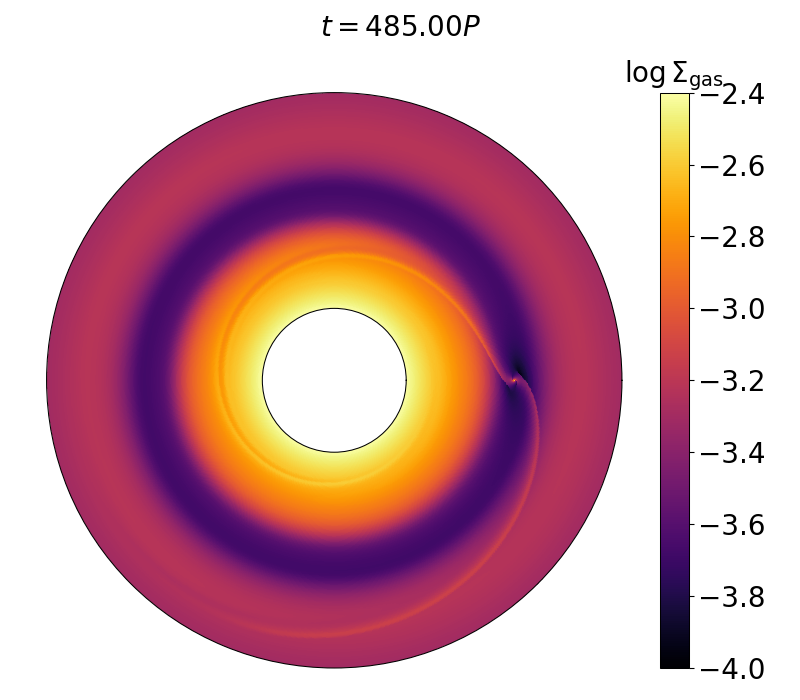

In [57]:
rxplt.plt_params('l'); fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={'projection': 'polar'}); ax.grid(False)

meshr, meshphi = np.meshgrid(ccr, ccphi)
im = ax.pcolormesh(meshphi, meshr, np.log10(dens_lev0), shading='nearest', cmap="inferno", vmin=-4, vmax=-2.4)

meshr, meshphi = np.meshgrid(ccr4, ccphi4)
im = ax.pcolormesh(meshphi, meshr, np.log10(dens_lev4), shading='nearest', cmap="inferno", vmin=-4, vmax=-2.4)

ax.set_rticks([]); ax.set_thetagrids([]); ax.set_rorigin(0); #ax.set_rlim([1, 4])
#ax.set_rlabel_position(-22.5) # in angle
cax = fig.colorbar(im); cax.ax.set_title(r"$\log \Sigma_{\rm gas}$")

def format_coord(_theta, _r):
    # _theta is from 0 to 2pi
        return f'θ={_theta/np.pi:.3f}π ({_theta*180/np.pi:.1f}°), r={_r:.3f}'

ax.format_coord = format_coord
fig.suptitle(r"$t="+f"{ds_raw['Time']/(2*np.pi):.2f}"+r"P$", fontsize=20); fig.tight_layout()

/tmp/ipykernel_27674/1739936736.py:3: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(ccr, ccphi, np.log10(dens_lev0), vmin=-4, vmax=-2.4)


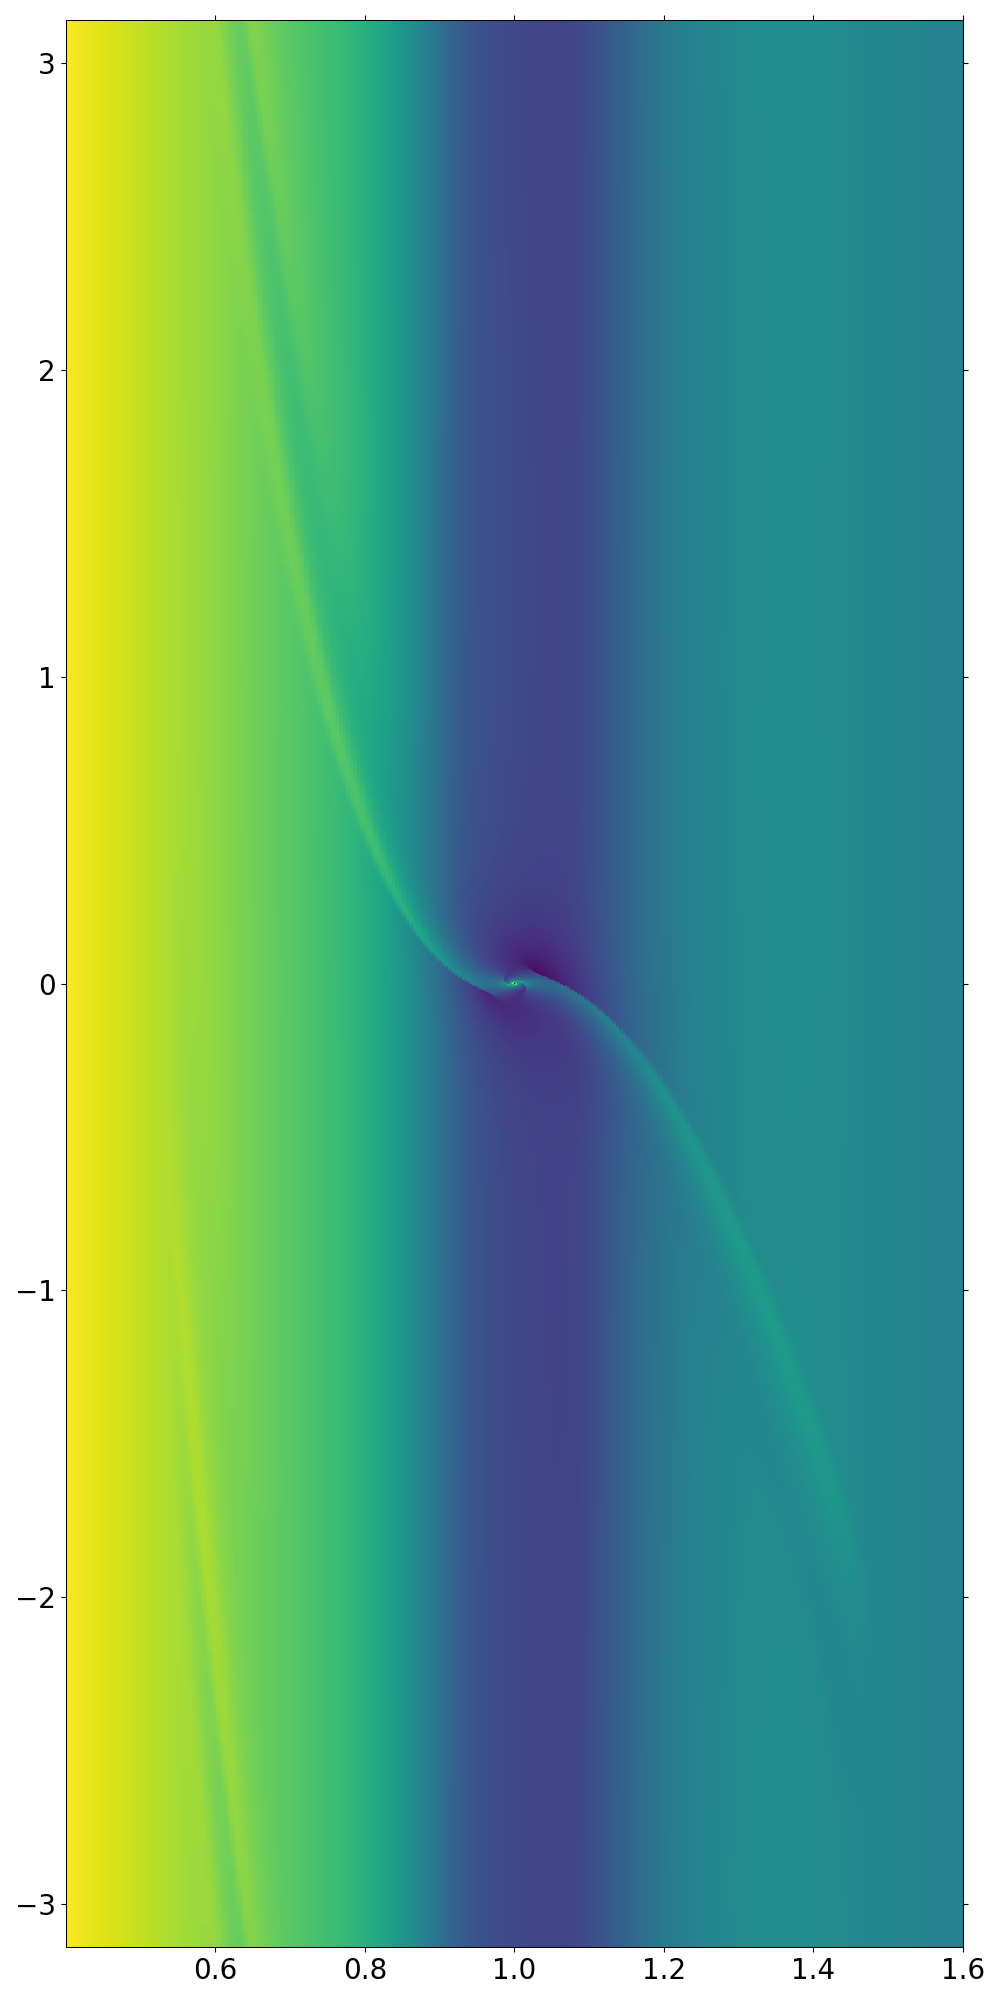

In [40]:
rxplt.plt_params('l'); fig, ax = plt.subplots(figsize=(10, 20))

ax.pcolormesh(ccr, ccphi, np.log10(dens_lev0), vmin=-4, vmax=-2.4)
ax.pcolormesh(ccr4, ccphi4, np.log10(dens_lev4), vmin=-4, vmax=-2.4)

fig.tight_layout()

In [63]:
ds_raw = athr.athdf("JTrunII_noAcc/ppd_cyl.out1.00485.athdf", raw=True, quantities=['dens', ], )

block_size = ds_raw['MeshBlockSize']
root_grid_size = ds_raw['RootGridSize']
levels = ds_raw['Levels'][:]
logical_locations = ds_raw['LogicalLocations'][:]


for lev in [6, 5, 4, 3, 2, 1]:
    logi_locs = logical_locations[levels==lev]
    logi_locs_parent = logi_locs // 2
    logi_locs_parent

    # to find and group fine mesh blocks that can be merged into coarse mesh blocks
    unq, count = np.unique(logi_locs_parent, axis=0, return_counts=True)
    repeated_groups = unq[count>1]
    
    re_levels = []
    re_logi_locs = []
    re_data = {'x1f': [], 'x1v': [], 'x2f': [], 'x2v': [], 'x3f': [], 'x3v': [], 
               'dens': [], }

    for repeated_group in repeated_groups:
        repeated_idx = np.argwhere(np.all(logi_locs_parent == repeated_group, axis=1))
        print(repeated_idx.ravel()) # one can check this so we know it is 3D

        # hard-coded for 3D
        idx_to_merge = np.argwhere(levels==lev)[repeated_idx.ravel()].ravel()

        # athr.athdf uses face coordinates to find the enclosure boundaries, so center-coordiantes are fine to capture the mesh blocks
        bounding_box = np.array([[ds_raw['x1v'][idx_to_merge].min(), ds_raw['x1v'][idx_to_merge].max()], 
                                 [ds_raw['x2v'][idx_to_merge].min(), ds_raw['x2v'][idx_to_merge].max()], 
                                 [ds_raw['x3v'][idx_to_merge].min(), ds_raw['x3v'][idx_to_merge].max()], 
                                ])
        #print(bounding_box)

        ds = athr.athdf("JTrunII_noAcc/ppd_cyl.out1.00485.athdf", level=lev-1, fast_restrict=True, quantities=['dens', ], max_level=min(6, lev-1+4),
                    x1_min=bounding_box[0][0], x1_max=bounding_box[0][1], x2_min=bounding_box[1][0], x2_max=bounding_box[1][1], x3_min=bounding_box[2][0], x3_max=bounding_box[2][1], )

        re_levels.append(lev-1)
        re_logi_locs.append(repeated_group)
        for _coord in ['x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', ]:
            re_data[_coord].append(ds[_coord])
        for _q in ['dens', ]:
            re_data[_q].append(ds[_q])

    levels = np.hstack([levels, np.atleast_1d(re_levels)])
    logical_locations = np.vstack([logical_locations, np.array(re_logi_locs)])
    for _coord in ['x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', ]:
        ds_raw[_coord] = np.vstack([ds_raw[_coord], np.array(re_data[_coord])])
    for _q in ['dens', ]:
        ds_raw[_q] = np.vstack([ds_raw[_q], np.array(re_data[_q])])

[0 1 2 3]
[ 8  9 10 11]
[4 5 6 7]
[12 13 14 15]
[ 0  1  2 12]
[ 6  7  8 13]
[ 3  4  5 14]
[ 9 10 11 15]
[0 1 2 3]
[30 31 32 33]
[4 5 6 7]
[34 35 36 37]
[ 8  9 10 11]
[38 39 40 41]
[12 13 14 60]
[42 43 44 61]
[15 16 17 62]
[45 46 47 63]
[18 19 20 21]
[48 49 50 51]
[22 23 24 25]
[52 53 54 55]
[26 27 28 29]
[56 57 58 59]
[0 1 2 3]
[16 17 18 19]
[ 4  5 32 34]
[20 21 33 35]
[ 6  7 36 38]
[22 23 37 39]
[ 8  9 40 42]
[24 25 41 43]
[10 11 44 46]
[26 27 45 47]
[12 13 14 15]
[28 29 30 31]
[ 0  1  2 20]
[10 11 12 21]
[ 3  4 22 24]
[13 14 23 25]
[ 5  6 26 28]
[15 16 27 29]
[ 7  8  9 30]
[17 18 19 31]
[0 1 2 3]
[12 13 14 15]
[ 4  5 24 26]
[16 17 25 27]
[ 6  7 28 30]
[18 19 29 31]
[ 8  9 10 11]
[20 21 22 23]


In [64]:
lev = 0
sel_mb_lev = np.where(levels == lev)[0]
logi_locs = logical_locations[sel_mb_lev]
anchor = logi_locs.min(axis=0)
logi_locs -= anchor
Nx_mb = ds_raw['MeshBlockSize']
Nx_lev = Nx_mb * (logi_locs.max(axis=0) + 1)  # b/c locs starts from 0
Nx_lev = (Nx_lev[:2]) # only 2 dimension
dens_lev0 = np.zeros(Nx_lev[::-1], dtype=np.float32)
ccr, ccphi = np.zeros(Nx_lev[0], dtype=np.float32), np.zeros(Nx_lev[1], dtype=np.float32)

for idx_sel_mb, idx_mb in enumerate(sel_mb_lev):
    #print(idx_sel_mb, idx_mb)
    _ccr, _ccphi = ds_raw['x1v'][idx_mb], ds_raw['x2v'][idx_mb]
    ccr[Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = _ccr
    ccphi[Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1)] = _ccphi
    
    dens_lev0[Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1),
              Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = ds_raw['dens'][idx_mb]


lev = 4
sel_mb_lev = np.where(levels == lev)[0]
logi_locs = logical_locations[sel_mb_lev]
anchor = logi_locs.min(axis=0)
logi_locs -= anchor
Nx_mb = ds_raw['MeshBlockSize']
Nx_lev = Nx_mb * (logi_locs.max(axis=0) + 1)  # b/c locs starts from 0
Nx_lev = (Nx_lev[:2]) # only 2 dimension
dens_lev4 = np.zeros(Nx_lev[::-1], dtype=np.float32)
ccr4, ccphi4 = np.zeros(Nx_lev[0], dtype=np.float32), np.zeros(Nx_lev[1], dtype=np.float32)

for idx_sel_mb, idx_mb in enumerate(sel_mb_lev):
    #print(idx_sel_mb, idx_mb)
    _ccr, _ccphi = ds_raw['x1v'][idx_mb], ds_raw['x2v'][idx_mb]
    ccr4[Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = _ccr
    ccphi4[Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1)] = _ccphi
    
    dens_lev4[Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1),
              Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = ds_raw['dens'][idx_mb]

/tmp/ipykernel_27674/3200231020.py:4: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(meshphi, meshr, np.log10(dens_lev0), shading='nearest', cmap="inferno", vmin=-4, vmax=-2.4)


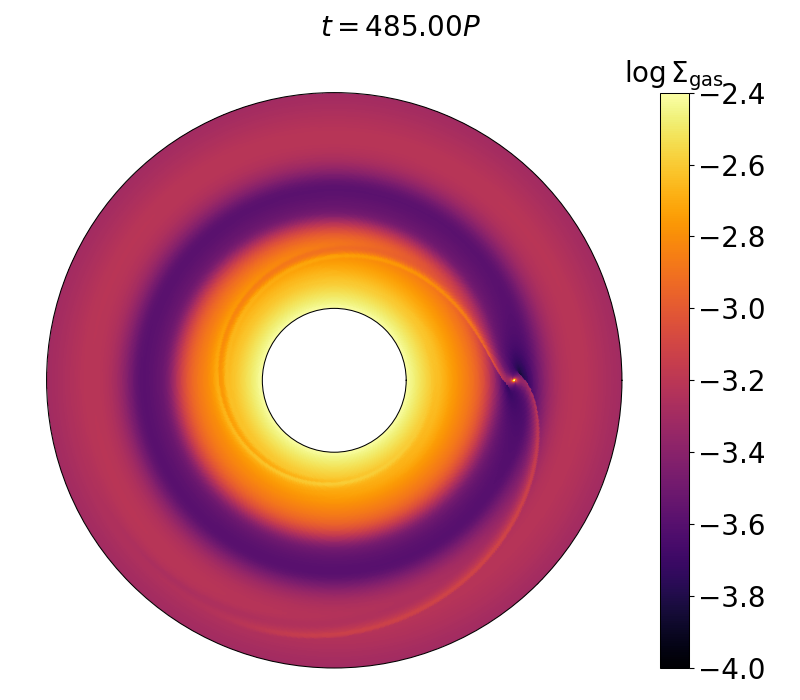

In [65]:
rxplt.plt_params('l'); fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={'projection': 'polar'}); ax.grid(False)

meshr, meshphi = np.meshgrid(ccr, ccphi)
im = ax.pcolormesh(meshphi, meshr, np.log10(dens_lev0), shading='nearest', cmap="inferno", vmin=-4, vmax=-2.4)

meshr, meshphi = np.meshgrid(ccr4, ccphi4)
im = ax.pcolormesh(meshphi, meshr, np.log10(dens_lev4), shading='nearest', cmap="inferno", vmin=-4, vmax=-2.4)

ax.set_rticks([]); ax.set_thetagrids([]); ax.set_rorigin(0); #ax.set_rlim([1, 4])
#ax.set_rlabel_position(-22.5) # in angle
cax = fig.colorbar(im); cax.ax.set_title(r"$\log \Sigma_{\rm gas}$")

def format_coord(_theta, _r):
    # _theta is from 0 to 2pi
        return f'θ={_theta/np.pi:.3f}π ({_theta*180/np.pi:.1f}°), r={_r:.3f}'

ax.format_coord = format_coord
fig.suptitle(r"$t="+f"{ds_raw['Time']/(2*np.pi):.2f}"+r"P$", fontsize=20); fig.tight_layout()